#Video Game Sales with Ratings
*Cas kaggle*

Gerard Benet Martínez - 1704125
Javier Emparan López - 1704634

---

## Definició del problema

Aquest projecte se centra en l'anàlisi predictiva de l'èxit comercial de videojocs, utilitzant una base de dades que integra una àmplia col·lecció de títols amb les seves mètriques de qualitat extretes principalment de la plataforma Metacritic.

- S'analitzaran les dades i s'aplicara els diferents tractaments de preprocesat.
- Es comprobaran les distintes metriques pels models de regresió i trobar el ideal pel nostre cas
- S'entrenaran distints models i es seleccionar el que doni millors resultats.

---



In [90]:
#importacio de llibreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, f1_score, accuracy_score, precision_recall_curve, auc, roc_curve, classification_report

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import kagglehub


In [91]:

# Importacio de les dades directament de Kaggle
path = kagglehub.dataset_download("rush4ratio/video-game-sales-with-ratings")

print("Path to dataset files:", path)
df = pd.read_csv(path + "/Video_Games_Sales_as_at_22_Dec_2016.csv")
print(df)
#inicialitzacio de dades importants
numeric_features = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']
categorical_features = ['Platform','Rating', 'Developer','Publisher', 'Genre']

Path to dataset files: /root/.cache/kagglehub/datasets/rush4ratio/video-game-sales-with-ratings/versions/2
                                Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16714  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16715               LMA Manager 2007     X360           2006.0        Sports   
16716        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16717               Spirits & Spells      GBA           2003.0      Platform   
16718        

## Visualització de les dades
En aquesta primera part fem una visualització inicial de les dades per a tenir una millor comprensió del problema i saber com afrontar-lo apropiadament.

In [92]:
#Funcions de visualització de dades
#Mostrar quantitat de NaNs
def mostrarGraficNaNs(dades):
  nan_counts_all = dades.isnull().sum()

  if not nan_counts_all.empty:
      plt.figure(figsize=(12, 6))

      nan_counts_all.plot(kind='bar', color='darkorange')

      plt.title('Quantitat de missing Values (NaN) per atribut', fontsize=16)
      plt.xlabel('Atributs', fontsize=12)
      plt.ylabel('Quantitat de NaNs', fontsize=12)

      for i, v in enumerate(nan_counts_all):
          plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10)

      plt.xticks(rotation=45, ha='right')
      plt.grid(axis='y', linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()


In [93]:
print("Nombre d'atributs:", len(df.columns))
print(df.describe())
print(df.info())

Nombre d'atributs: 16
       Year_of_Release      NA_Sales      EU_Sales      JP_Sales  \
count     16450.000000  16719.000000  16719.000000  16719.000000   
mean       2006.487356      0.263330      0.145025      0.077602   
std           5.878995      0.813514      0.503283      0.308818   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.020000      0.000000   
75%        2010.000000      0.240000      0.110000      0.040000   
max        2020.000000     41.360000     28.960000     10.220000   

        Other_Sales  Global_Sales  Critic_Score  Critic_Count    User_Count  
count  16719.000000  16719.000000   8137.000000   8137.000000   7590.000000  
mean       0.047332      0.533543     68.967679     26.360821    162.229908  
std        0.186710      1.547935     13.938165     18.980495    561.282326  
min        0.000000      0.010000     13.000000      

Per una part, podem veure que hi ha tant dades categoriques com dades no categoriques.
- Per la part de dades categoriques estan la plataforma on s'ha publicat el joc (platform), el genere del joc, el publisher, la desenvolupadora i el rating. També podem veure que el user_score no surt com a numeric, pero per que hi ha valors "tbd", els cuals haurem de tractar mes endavant.

- Per la part de dades no categoriques trobem l'any de publicació del joc, les ventes tant en NA, EU, JP, globals i altres, els tipus de valoració que hi ha, tant per la part de critics com d'usuari.

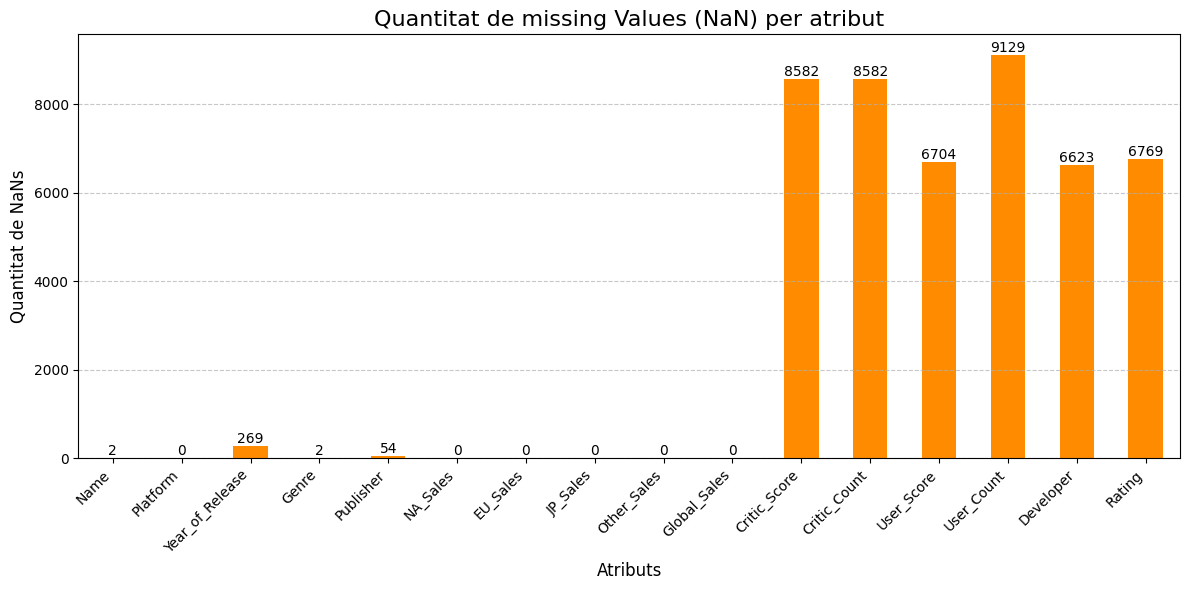

In [94]:
mostrarGraficNaNs(df)

Podem destacar que hi ha una gran quantitat de NaNs en les categories de valoracions (critic/user score i critic/user count), a més de la categoria Developer i rating. També podem veure una petita quantitat de NaNs en l'any de publicació i el publisher del joc.

Per la gran quantita de NaNs que hi ha, no podem optar a eliminar-los completament, ja que aixó reduiria la quantitat de dades drasticament, per tant, optarem per omplir-los.


---
## Preprocessament de dades


---
### Tractament de NaNs

Per una part, com hem vist a la part de visualització de dades, la columna "User_Score" es considerada categorica ja que conté dades "to be determined". Aquestes dades les tractarem com NaNs per poder tractarles mes endavant correctament amb la resta de missing values.

Una vegada tractats els "tbd" podem veure que la puntuació i la cuantitat de valoracions de user/crits encaixen.

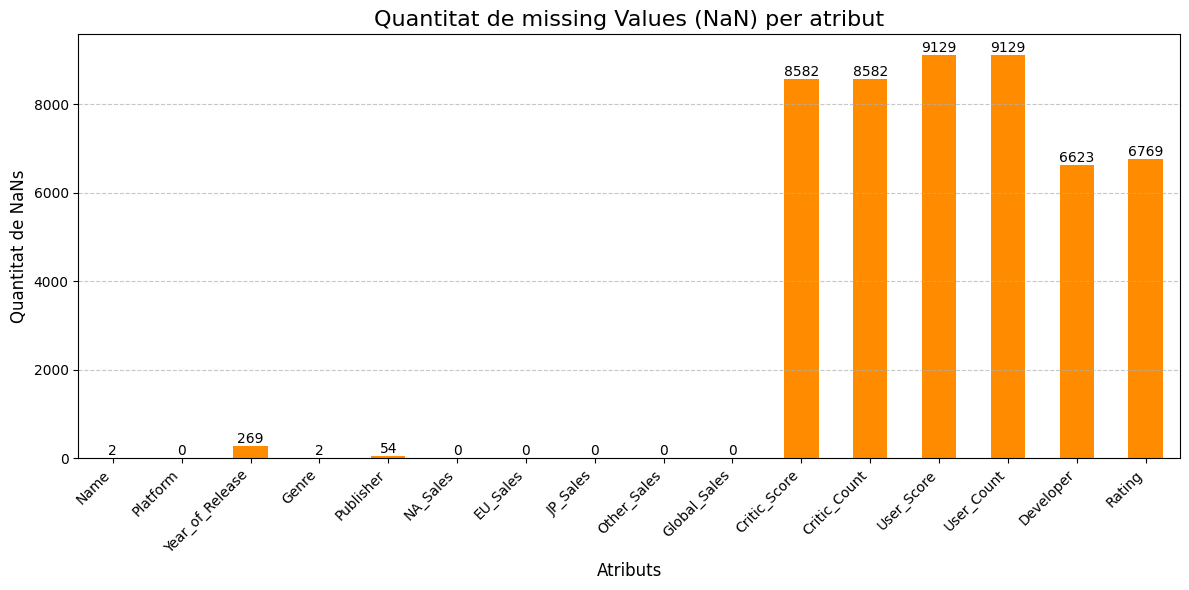

In [95]:
df['User_Score'] = df['User_Score'].replace('tbd', np.nan) #En la columna user score hay tbd. Esto transforma esos en NaNs
df['User_Score'] = pd.to_numeric(df['User_Score']) #Pasarlo a float64 y tal
df_fixed = df
mostrarGraficNaNs(df_fixed)


Una vegada fet aixó, podem començar a procesar els NaNs. Hem decidit utilitzar un SimplerImputer, on per omplir els valors numerics utilitzarem  la mediana i per les categoriques utilitzarem la moda.



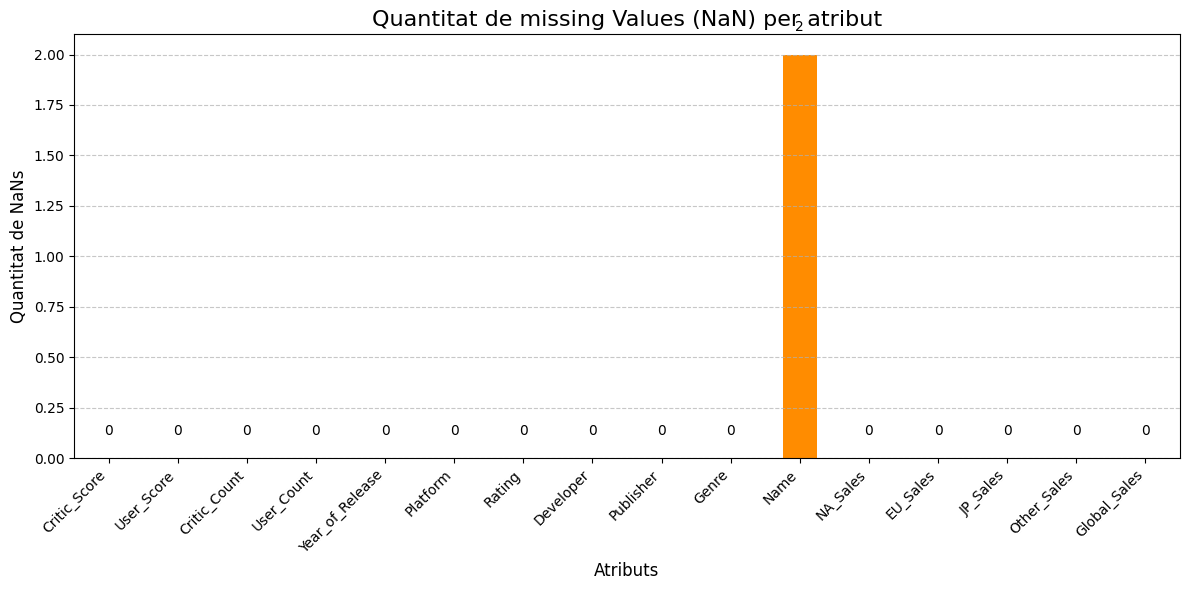

In [96]:
numeric_features = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']
categorical_features = ['Platform','Rating', 'Developer','Publisher', 'Genre']



numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)


df_pre_imputed = preprocessor.fit_transform(df_fixed)

columnas_procesadas = numeric_features + categorical_features
columnas_passthrough = [col for col in df_fixed.columns if col not in columnas_procesadas]
columnas_resultado_completo = numeric_features + categorical_features + columnas_passthrough

df_imputed = pd.DataFrame(
    df_pre_imputed,
    columns=columnas_resultado_completo,
    index=df_fixed.index
)

mostrarGraficNaNs(df_imputed)


---
### Data scaling

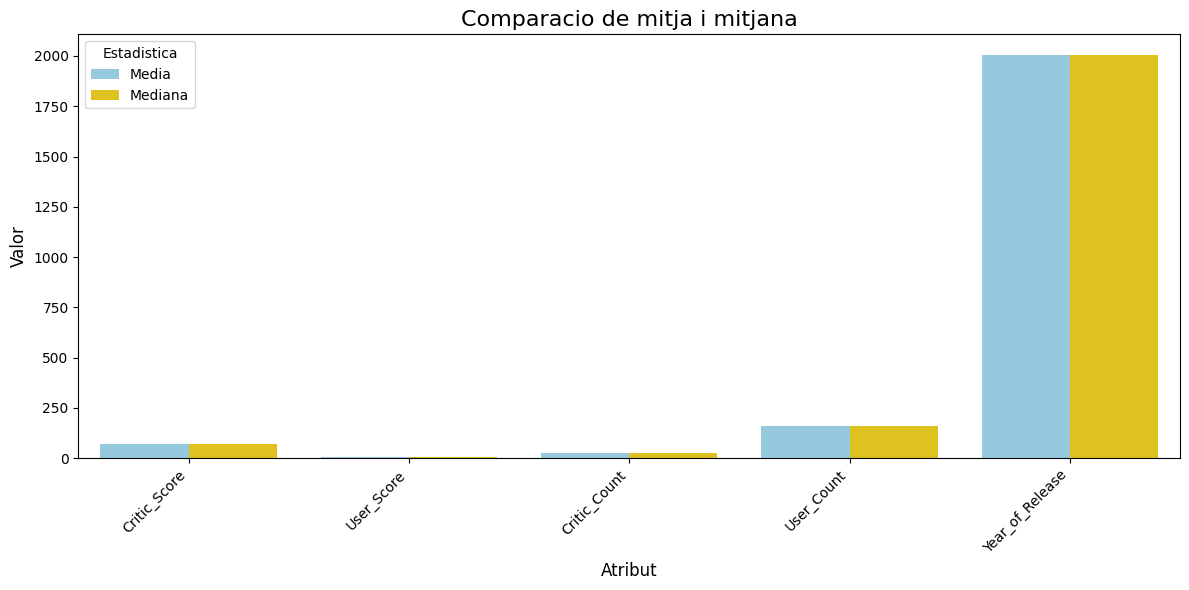

In [97]:
atributosNumericos = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count','Year_of_Release']

df_numeric_data = df_imputed[atributosNumericos]
df2 = df_imputed[atributosNumericos]
atributos_numericos = numeric_features
# -----------------------------------------------------
medias = df2[atributosNumericos].mean().rename('Media')
medianas = df2[atributosNumericos].median().rename('Mediana')

df_stats = pd.concat([medias, medianas], axis=1)

df_plot = df_stats.reset_index().melt(
    id_vars='index',
    var_name='Estadística',
    value_name='Valor'
)

df_plot = df_plot.rename(columns={'index': 'Atributo'})

plt.figure(figsize=(12, 6))

sns.barplot(
    x='Atributo',
    y='Valor',
    hue='Estadística',
    data=df_plot,
    palette={'Media': 'skyblue', 'Mediana': 'gold'}
)
plt.title('Comparacio de mitja i mitjana', fontsize=16)
plt.xlabel('Atribut', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend(title='Estadistica')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Per evitar el biaix de caracteristiques i millorar la convergencia mes endavant quan començem a entrenar els models, probarem diferents scalers. (explicar)

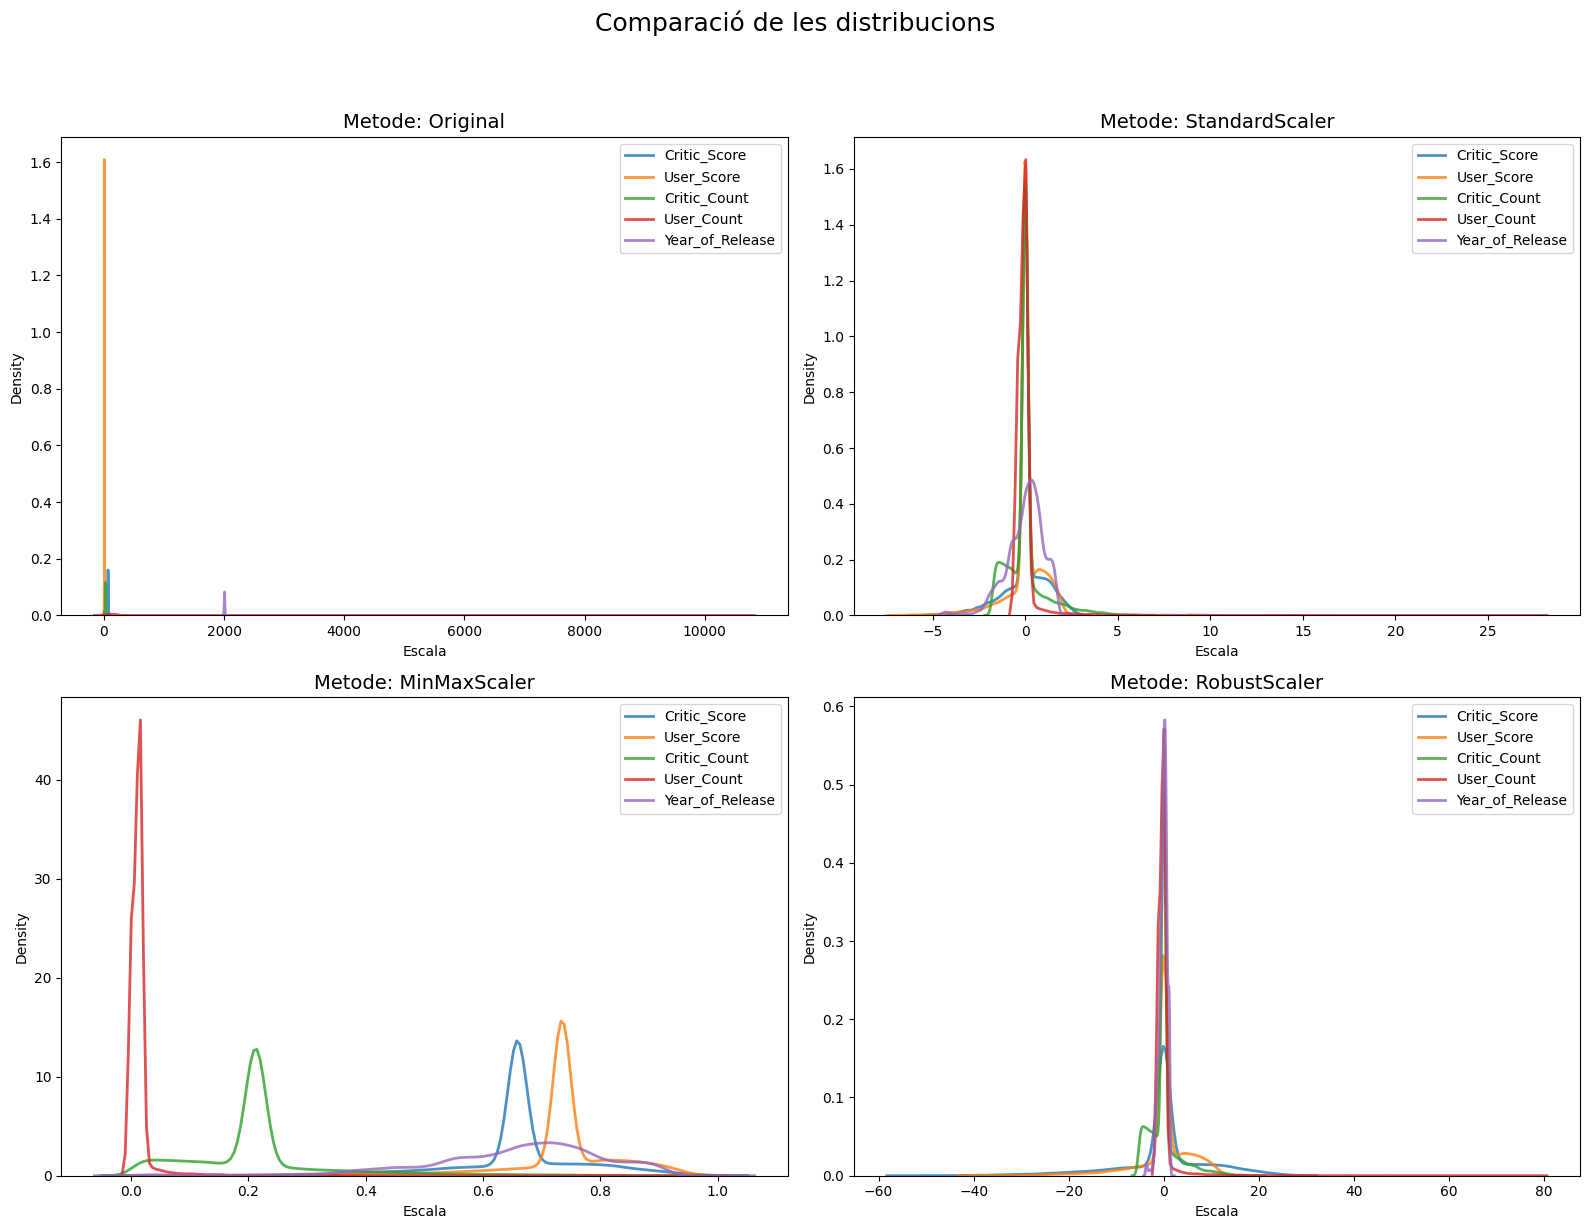

In [98]:
df_numeric_data = df_imputed[numeric_features]

scalers = {
    "Original": df_numeric_data.copy(),
    "StandardScaler": pd.DataFrame(StandardScaler().fit_transform(df_numeric_data), columns=numeric_features),
    "MinMaxScaler": pd.DataFrame(MinMaxScaler().fit_transform(df_numeric_data), columns=numeric_features),
    "RobustScaler": pd.DataFrame(RobustScaler().fit_transform(df_numeric_data), columns=numeric_features)}

plot_cols = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']

plt.figure(figsize=(16, 12))
plt.suptitle('Comparació de les distribucions', fontsize=18, y=1.02)

for i, (name, scaled) in enumerate(scalers.items(), 1):
    plt.subplot(2, 2, i)
    for col in plot_cols:
         sns.kdeplot(scaled[col], fill=False, label=col, alpha=0.8, linewidth=2)

    plt.title(f'Metode: {name}', fontsize=14)
    plt.xlabel('Escala')
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

df_scaled = df_imputed.copy()
df_scaled.update(scalers["RobustScaler"])



---
### Tractament de dades categóriques


Per altra banda, també hem de tractar els atributs categorics previament mencionats.

Si mirem la quantita de valors unics per cada atribut (Platform, Rating, Developer, etc), podem veure que en developer y publisher hi ha una gran quantitat de valors unics. Codificar aquests amb un label/ordinal/onehot encoder pot donar problemes. Per solventar aixó, hem decidit tenir en compte els publishers. Amb aquests, els hem agrupat en 3 grups depenent del nombre de jocs que han publicat.
Per altra hem codificat el rating amb un ordinal encoder, de jocs per petits fins a nomes adults.
Per ultim, hem decidit aplicar onehot encoder al genere del joc.

In [99]:
columnas_categoricas = categorical_features

# 2. Iterar sobre las columnas y mostrar los valores únicos
for columna in columnas_categoricas:
    # Usamos .unique() para obtener la lista de valores únicos
    valores_unicos = df_scaled[columna].unique()

    # Imprimir el resultado
    print(f"\nAtribut: {columna}")
    print(f"Nombre de valors unics: {len(valores_unicos)}")
    # Se imprime solo una muestra para evitar listas muy largas
    print(f"Valors unics: {valores_unicos[:10]}")

    # Si la columna tiene muchos valores únicos, es mejor solo mostrar el conteo
    if len(valores_unicos) > 20:
        print(f"Hi ha mes de 20!")


Atribut: Platform
Nombre de valors unics: 31
Valors unics: ['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4']
Hi ha mes de 20!

Atribut: Rating
Nombre de valors unics: 8
Valors unics: ['E' 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']

Atribut: Developer
Nombre de valors unics: 1696
Valors unics: ['Nintendo' 'Ubisoft' 'Good Science Studio' 'Rockstar North'
 'Polyphony Digital' 'Infinity Ward, Sledgehammer Games' 'Treyarch'
 'Infinity Ward' 'DMA Design' 'Game Arts']
Hi ha mes de 20!

Atribut: Publisher
Nombre de valors unics: 581
Valors unics: ['Nintendo' 'Microsoft Game Studios' 'Take-Two Interactive'
 'Sony Computer Entertainment' 'Activision' 'Ubisoft' 'Bethesda Softworks'
 'Electronic Arts' 'Sega' 'SquareSoft']
Hi ha mes de 20!

Atribut: Genre
Nombre de valors unics: 12
Valors unics: ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting']


In [100]:
publisher_counts = df_scaled.groupby('Publisher')['Name'].transform('count')

def classify_by_count(count):
    if count >= 300:
        return 'Gran'
    elif count >= 50:
        return 'Mitja'
    else:
        return 'Petit'

# 3. Aplicar la clasificación y crear la nueva característica segura
df_scaled['Publisher_Tier_Safe'] = publisher_counts.apply(classify_by_count)


# --- Resultados ---
print("Exemple de les primeres files:")
print(df_scaled[['Publisher', 'Publisher_Tier_Safe']].head())
print("\nQuantitat de Publishers per Tier:")
print(df_scaled['Publisher_Tier_Safe'].value_counts())
print("-" * 60)

Exemple de les primeres files:
  Publisher Publisher_Tier_Safe
0  Nintendo                Gran
1  Nintendo                Gran
2  Nintendo                Gran
3  Nintendo                Gran
4  Nintendo                Gran

Quantitat de Publishers per Tier:
Publisher_Tier_Safe
Gran     9370
Mitja    3970
Petit    3379
Name: count, dtype: int64
------------------------------------------------------------


In [101]:
#ORDINAL ENCODER
rating_categories = [
    ['RP', 'EC', 'K-A', 'E', 'E10+', 'T', 'M', 'AO']
]
ordinal_encoder = OrdinalEncoder(categories=rating_categories)
rating_column = df_scaled[['Rating']]
rating_encoded_array = ordinal_encoder.fit_transform(rating_column)
df_scaled['Rating_Encoded'] = rating_encoded_array.flatten()
df_scaled.drop('Rating', axis=1, inplace=True)


# ONEHOT ENCODER
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
genre_column = df_scaled[['Genre']]
genre_encoded_array = onehot_encoder.fit_transform(genre_column)
new_genre_cols = onehot_encoder.get_feature_names_out(['Genre'])
df_genre_encoded = pd.DataFrame(
    genre_encoded_array,
    columns=new_genre_cols,
    index=df_scaled.index
)

df_scaled = pd.concat([df_scaled.drop('Genre', axis=1), df_genre_encoded], axis=1)

print(df_scaled.columns)


Index(['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count',
       'Year_of_Release', 'Platform', 'Developer', 'Publisher', 'Name',
       'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales',
       'Publisher_Tier_Safe', 'Rating_Encoded', 'Genre_Action',
       'Genre_Adventure', 'Genre_Fighting', 'Genre_Misc', 'Genre_Platform',
       'Genre_Puzzle', 'Genre_Racing', 'Genre_Role-Playing', 'Genre_Shooter',
       'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy'],
      dtype='object')


---
## Selecció de mètriques
Una vegada preprocesades les dades, seleccionem la millor mètrica pel problema

MSE, RMSE,R^2

Errores grandes son catastróficos,RMSE,Penaliza fuertemente los outliers o grandes desviaciones debido al término cuadrático.

Todos los errores son iguales,MAE,Trata todas las desviaciones por igual; es la más fácil de explicar a personas sin conocimientos técnicos.

Necesitas un resumen del ajuste,R2,Te da el contexto de qué tan útil es tu modelo en comparación con un modelo base simple (la media).

---
## Selecció del model
Una vegada seleccionada la millor mètrica, seleccionarem el millor model pel problema

---
## Anàlisis final
